In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
mnist = fetch_openml('SignMNIST', as_frame=False, cache=False)

C:\Users\phanm\miniconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
type(mnist)

sklearn.utils._bunch.Bunch

In [4]:
mnist.data.shape

(34627, 784)

In [5]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [6]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [6]:
X /= 255.0

In [7]:
X.min(), X.max()

(0.0, 1.0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [12]:
X_train.shape, y_train.shape

((25970, 784), (25970,))

In [13]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

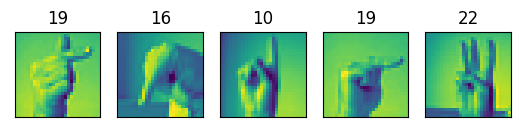

In [16]:
plot_example(X_train, y_train)

In [58]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
hidden_dim2 = int(hidden_dim/2)
output_dim = len(np.unique(mnist.target)) + 1

In [59]:
mnist_dim, hidden_dim, hidden_dim2, output_dim

(784, 98, 49, 25)

In [115]:
class MnistClassifier(nn.Module):
    def __init__(self,
                 input_dim=mnist_dim,
                 hidden_dim=hidden_dim,
                 hidden_dim2=hidden_dim2,
                 output_dim=output_dim,
                 dropout=0,
    ):
        super(MnistClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim2)
        self.output = nn.Linear(hidden_dim2, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.relu(self.hidden2(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

In [116]:
torch.manual_seed(0)

net = NeuralNetClassifier(MnistClassifier,
                          max_epochs=100, 
                          lr=0.02
)

In [117]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.1954       0.0653        3.1765  0.4810
      2        3.1541       0.0992        3.1248  0.4692
      3        3.0769       0.1194        3.0083  0.4940
      4        2.9173       0.1644        2.8203  0.4940
      5        2.7413       0.2187        2.6596  0.4950
      6        2.5785       0.2545        2.4753  0.4785
      7        2.3751       0.2876        2.2594  0.4820
      8        2.1707       0.3335        2.0863  0.4840
      9        2.0186       0.3560        1.9776  0.4837
     10        1.9115       0.3770        1.8973  0.4885
     11        1.8227       0.4116        1.8051  0.4719
     12        1.7434       0.4428        1.7213  0.4880
     13        1.6708       0.4607        1.6629  0.4877
     14        1.5954       0.4846        1.5855  0.4870
     15        1.5243       0.5017        1.5343  0.4750
     16        1.4642       0.5

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MnistClassifier(
    (dropout): Dropout(p=0, inplace=False)
    (hidden): Linear(in_features=784, out_features=98, bias=True)
    (hidden2): Linear(in_features=98, out_features=49, bias=True)
    (output): Linear(in_features=49, out_features=25, bias=True)
  ),
)

In [118]:
y_pred = net.predict(X_test)
accuracy_score(y_test, y_pred)

0.9956104886219245

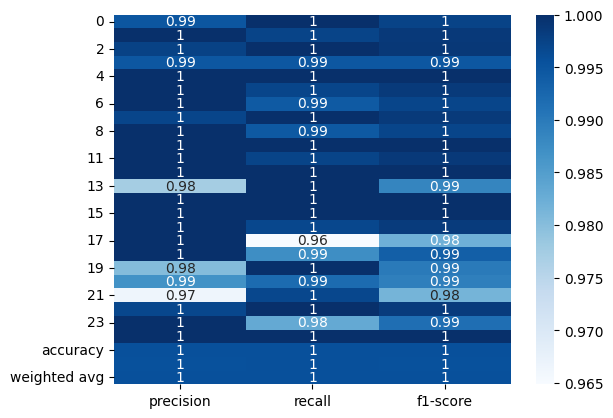

In [157]:
cl_report = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(cl_report).iloc[:-1, :].T, annot=True, cmap="Blues")
plt.show()

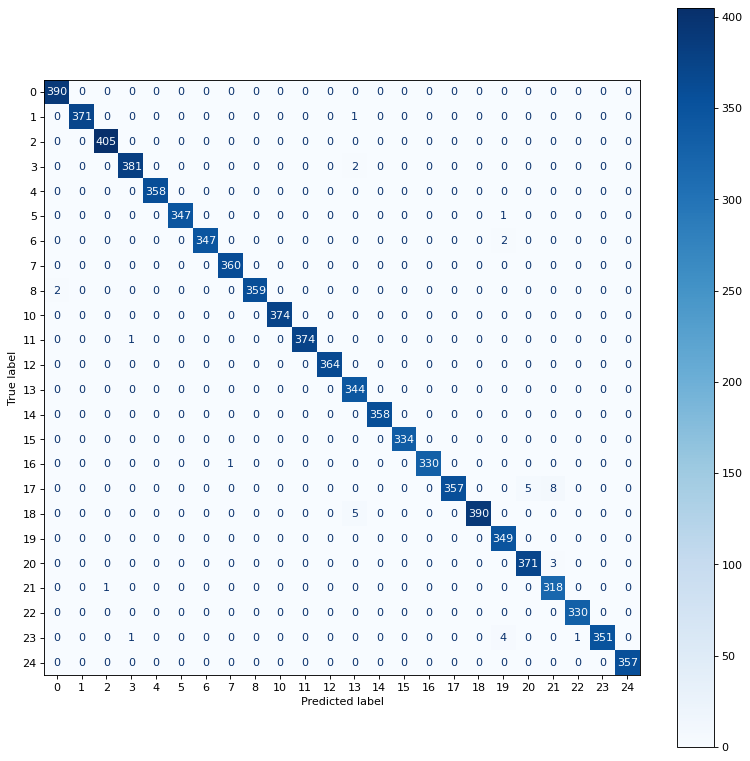

In [151]:
cm = confusion_matrix(y_test, y_pred, labels=net.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=net.classes_)
fig, ax = plt.subplots(figsize=(12,12), dpi=80)
disp.plot(ax=ax, cmap="Blues")
plt.show()

In [152]:
y_train_pred = net.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9968810165575664

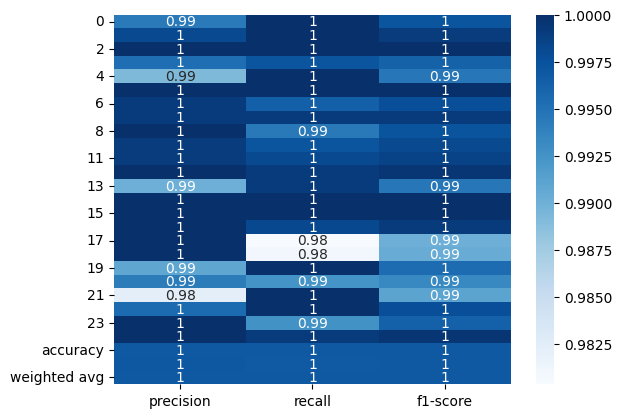

In [159]:
cl_report_train = classification_report(y_train, y_train_pred, output_dict=True)
sns.heatmap(pd.DataFrame(cl_report_train).iloc[:-1, :].T, annot=True, cmap="Blues")
plt.show()

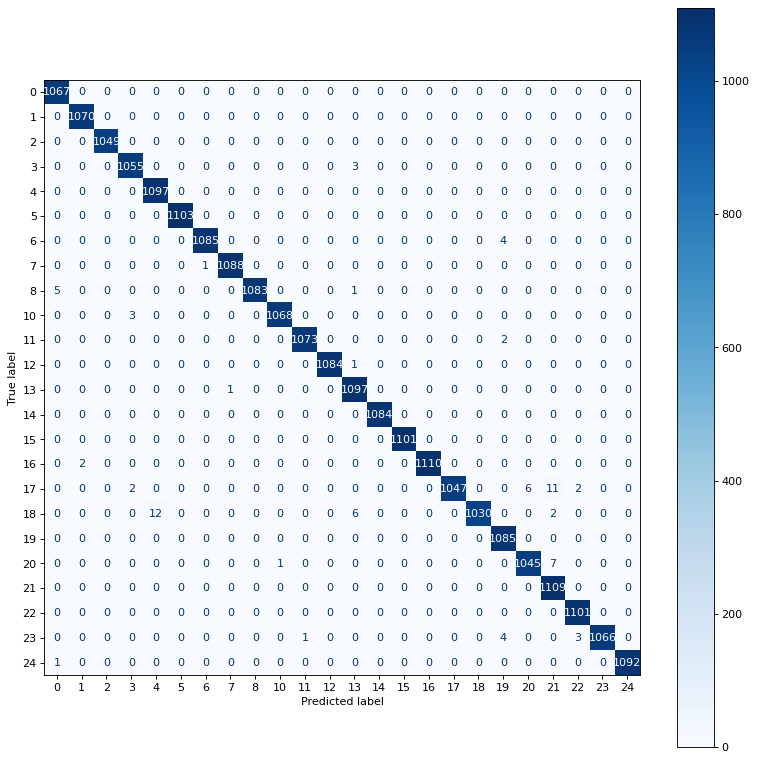

In [160]:
cm2 = confusion_matrix(y_train, y_train_pred, labels=net.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=net.classes_)
fig, ax = plt.subplots(figsize=(12,12), dpi=80)
disp2.plot(ax=ax, cmap="Blues")
plt.show()

In [162]:
torch.save(net, r"best_models\fc_nn.pt")

In [163]:
new_model = torch.load(r"best_models\fc_nn.pt")

In [164]:
y_pred = new_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9956104886219245